In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import os

In [2]:
df = pd.read_csv(r'C:\Users\NickBowen\Projects\NFL Data Project\Game Data\NFL_TeamGame_Stats2024 - Sheet1.csv')

In [2]:
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: c:\Users\NickBowen\Documents\NFL Data\2024 Weekly Game Data


In [3]:
df.head()

,Week,Team,Opponent,Location,Stadium Type,First Downs,Rushing Attempts,Rushing Yards,Rushing Touchdowns,Passing Completions,...,Total 3rd Down Attempts,Total 3rd Down Completions,3rd Down Conversion,Total 4th Down Attempts,Total 4th Down Completions,4th Down Conversion,Time of Possesion,Points,Opponent Points,Win/Loss
0,1,Ravens,Chiefs,Away,Outdoor,25,32,185,1,26,...,14,7,0.500000,2,1,0.5,33:43:00,20,27,Loss
1,1,Chiefs,Ravens,Home,Outdoor,21,20,72,2,20,...,9,4,0.444444,0,0,NaN,26:17:00,27,20,Win
2,1,Packers,Eagles,Home,International,19,21,163,1,17,...,11,3,0.272727,1,1,1.0,27:13:00,29,34,Loss
3,1,Eagles,Packers,Away,International,25,38,144,2,20,...,14,4,0.285714,1,1,1.0,32:47:00,34,29,Win
4,1,Steelers,Falcons,Away,Indoor,16,41,137,0,17,...,17,8,0.470588,1,0,0.0,35:36:00,18,10,Win


In [4]:
print(df.columns)

Index(['Week', 'Team', 'Opponent', 'Location', 'Stadium Type', 'First Downs',
       'Rushing Attempts', 'Rushing Yards', 'Rushing Touchdowns',
       'Passing Completions', 'Passing Attempts', 'Passing Yards',
       'Passing Touchdowns', 'Interceptions', 'Total Sacks',
       'Total Sack Yards', 'Total Fumbles', 'Total Fumbles Lost', 'Turnovers',
       'Total Penalties', 'Total Penalty Yards', 'Total 3rd Down Attempts',
       'Total 3rd Down Completions', '3rd Down Conversion',
       'Total 4th Down Attempts', 'Total 4th Down Completions',
       '4th Down Conversion', 'Time of Possesion', 'Points', 'Opponent Points',
       'Win/Loss'],
      dtype='object')


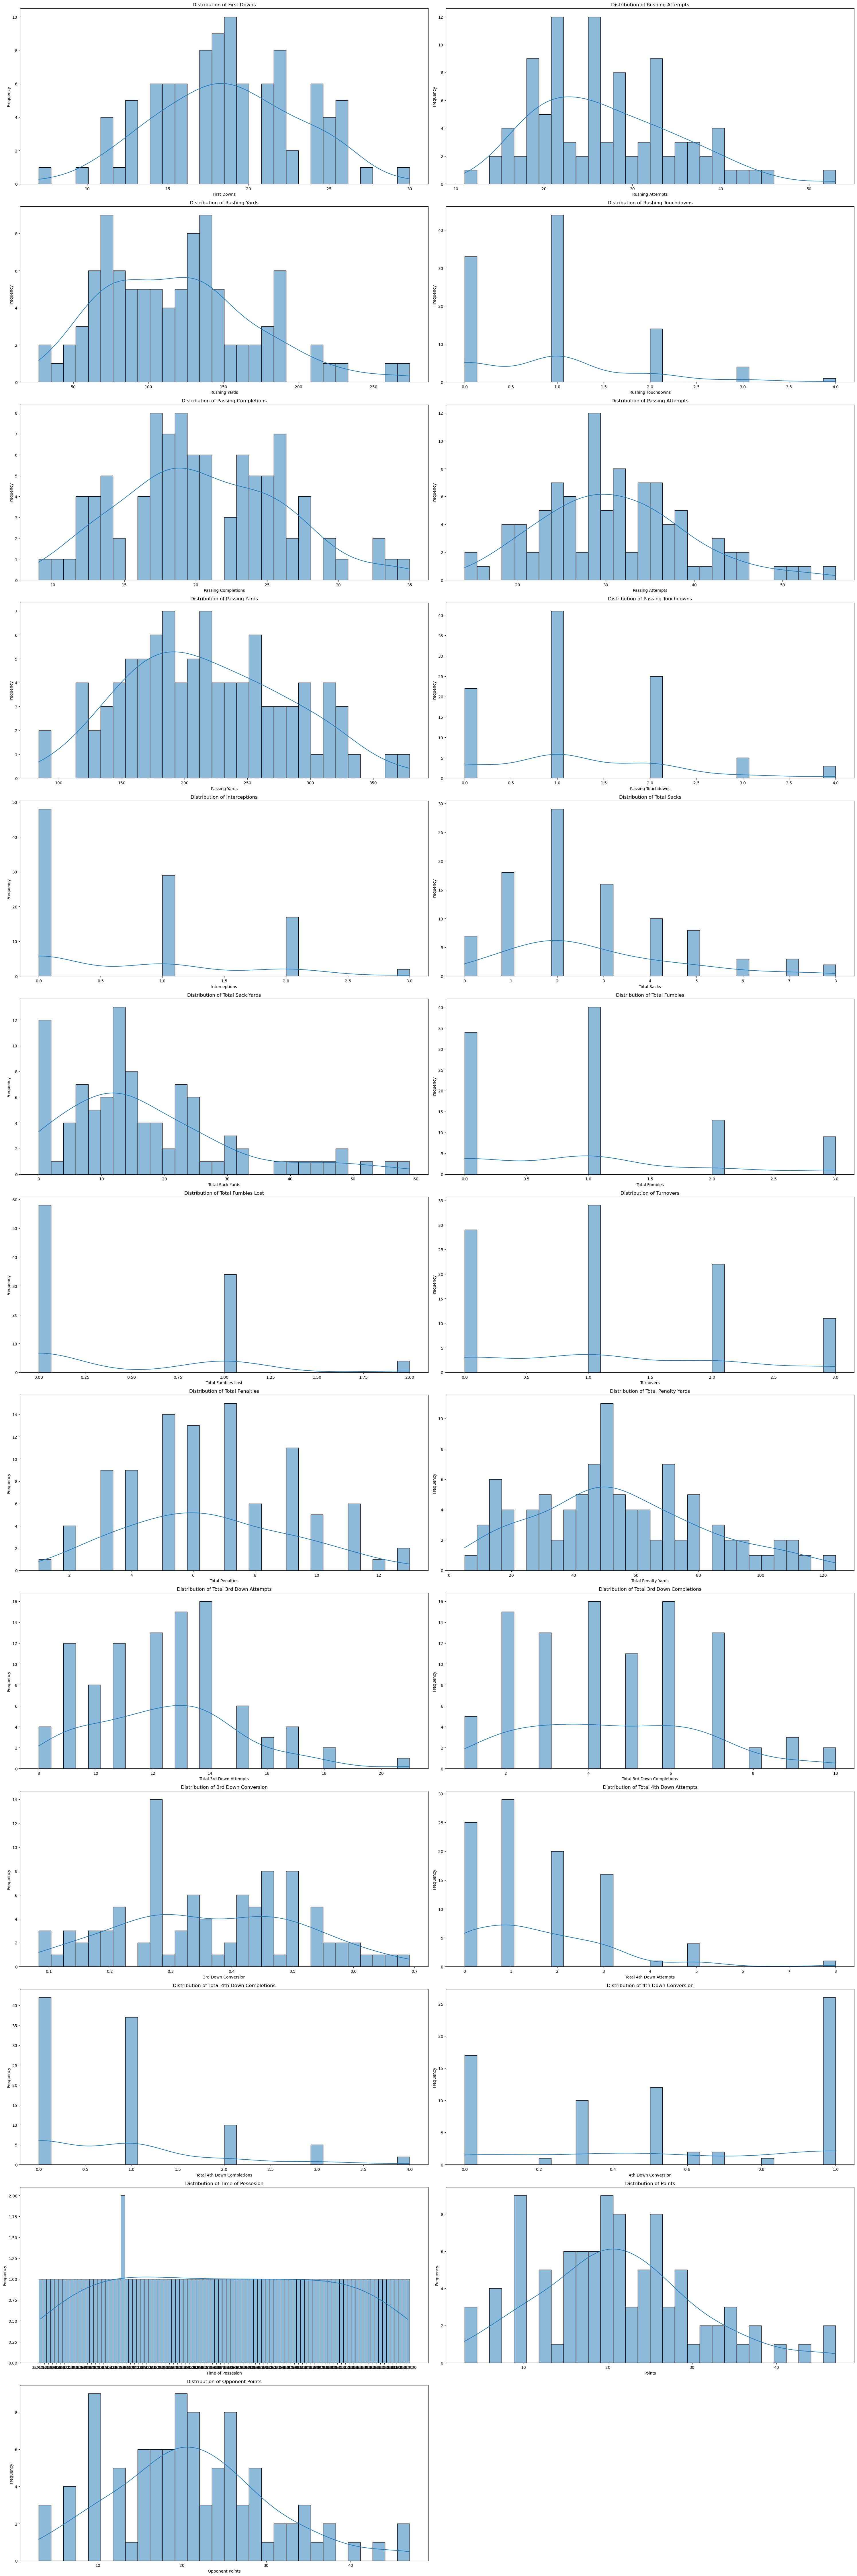

In [13]:
# loop that shows distribution of each column

drop_cols = ['Week','Team','Opponent','Location','Stadium Type','Win/Loss']

plot_cols = df.columns[~df.columns.isin(drop_cols)]

num_plots = len(plot_cols)
num_rows = (num_plots + 1) // 2  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 2, figsize=(30, 90))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, column in enumerate(plot_cols):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i])  # Plot histogram with KDE
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_aspect(aspect='auto')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

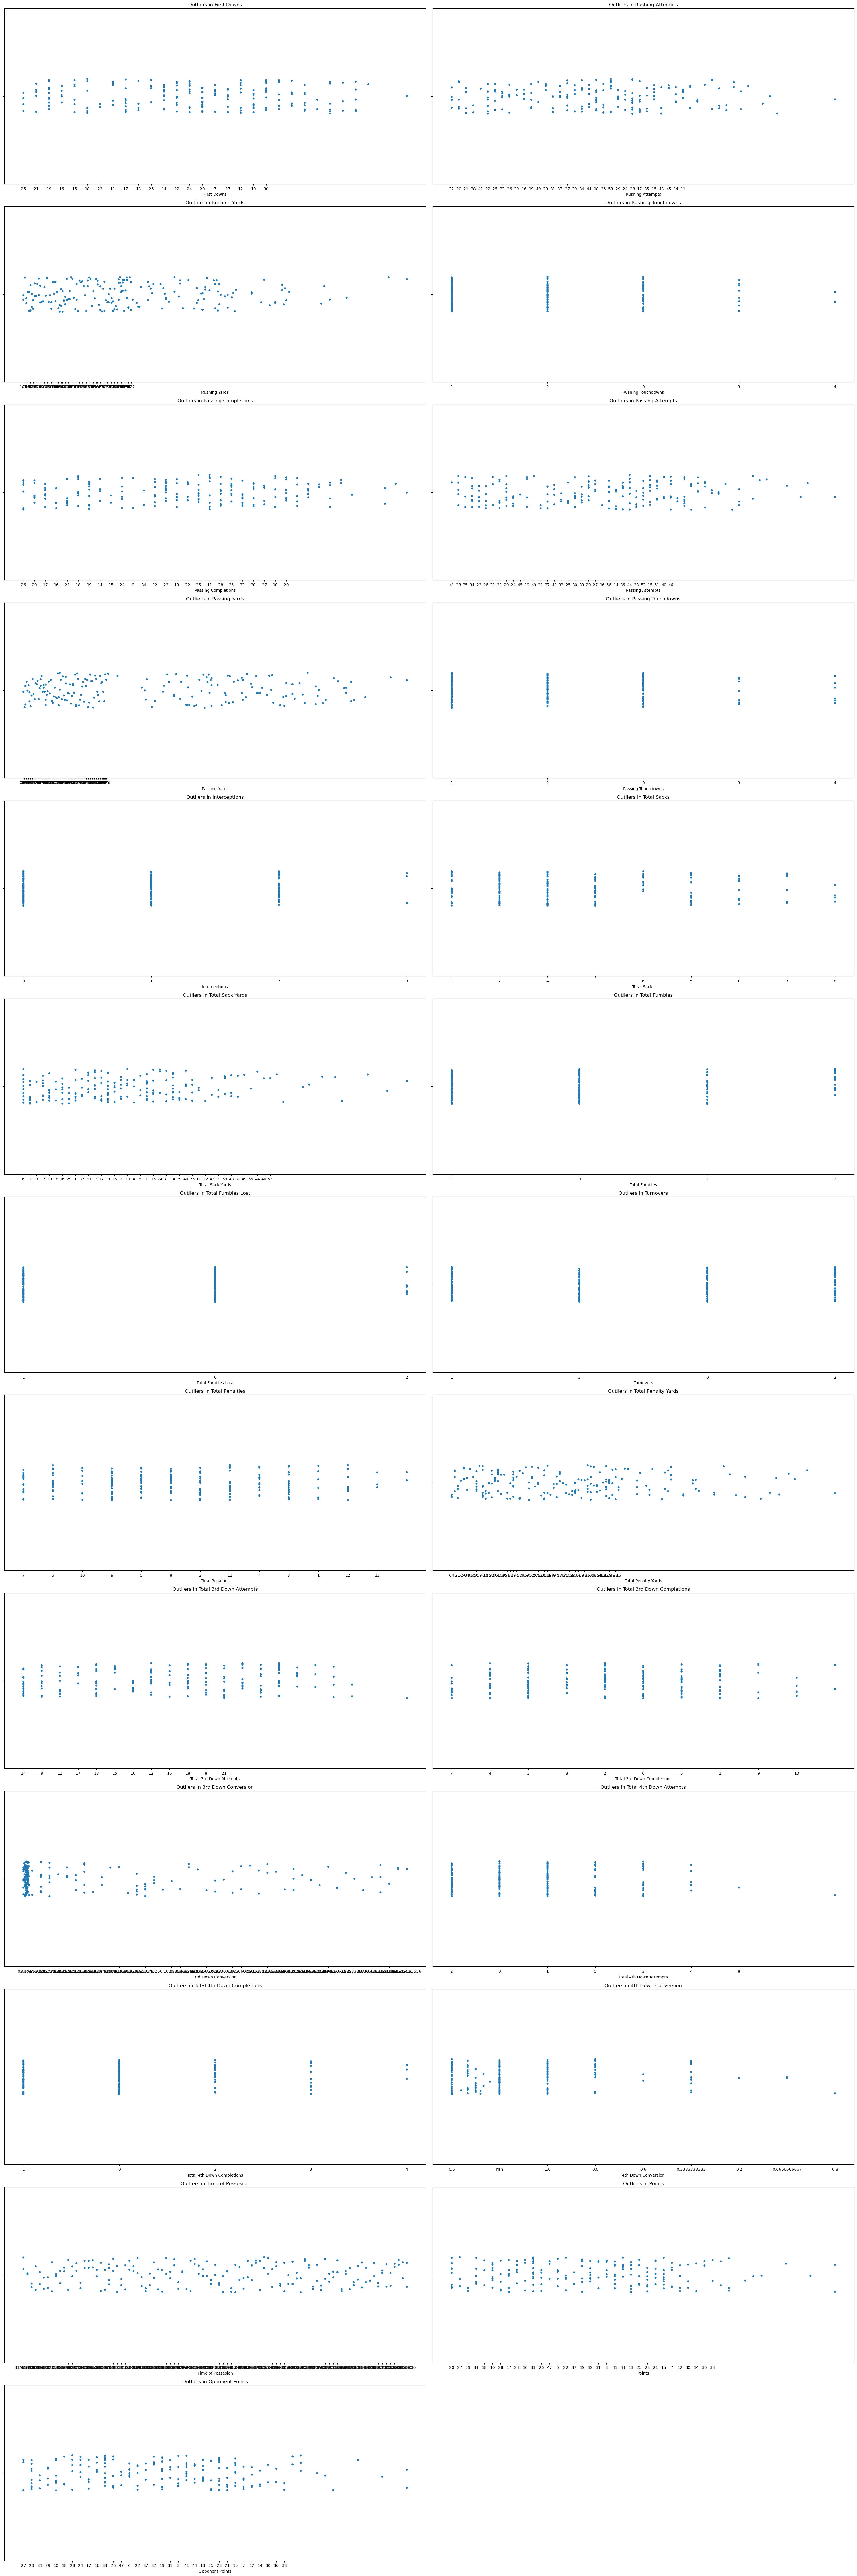

In [14]:
# loop that shows the outliers in each column

drop_cols = ['Week','Team','Opponent','Location','Stadium Type','Win/Loss']

plot_cols = df.columns[~df.columns.isin(drop_cols)]

num_plots = len(plot_cols)
num_rows = (num_plots + 1) // 2  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 2, figsize=(30, 90))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, column in enumerate(plot_cols):
    # Convert float values to strings for plotting
    sns.stripplot(x=df[column].astype(str), ax=axes[i], jitter=True)  # Create dot plot
    sns.stripplot(x=df[column], ax=axes[i], jitter=True)  # Create dot plot
    axes[i].set_title(f'Outliers in {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
df.dtypes

Week                            int64
Team                           object
Opponent                       object
Location                       object
Stadium Type                   object
First Downs                     int64
Rushing Attempts                int64
Rushing Yards                   int64
Rushing Touchdowns              int64
Passing Completions             int64
Passing Attempts                int64
Passing Yards                   int64
Passing Touchdowns              int64
Interceptions                   int64
Total Sacks                     int64
Total Sack Yards                int64
Total Fumbles                   int64
Total Fumbles Lost              int64
Turnovers                       int64
Total Penalties                 int64
Total Penalty Yards             int64
Total 3rd Down Attempts         int64
Total 3rd Down Completions      int64
3rd Down Conversion           float64
Total 4th Down Attempts         int64
Total 4th Down Completions      int64
4th Down Con

In [16]:
# Loop through the columns and check data types
for column in df.columns:
    # Get the unique data types in the column
    unique_dtypes = df[column].apply(type).unique()
    
    # Check if there are multiple data types
    if len(unique_dtypes) > 1:
        print(f"Column '{column}' has multiple data types: {unique_dtypes}")

In [5]:
# Split the data into features and target
X = df.drop(['Points','Week','Win/Loss','Opponent Points','Time of Possesion','Opponent','Team'], axis=1)
y = df['Points']

In [6]:
#defining categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Create a column transformer for one-hot encoding and imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Ignore unknown categories
        ]), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), X.select_dtypes(include=['float64', 'int64']).columns)  # Impute missing values with the mean for numerical columns
    ],
    remainder='passthrough'  # Keep the rest of the columns unchanged
)

In [9]:
# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [10]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Location', 'Stadium Type']),
                                                 ('num', SimpleImputer(),
                                                  Index(['First Downs', 'Rushing Attempts', 'Rushing Yards',
       'Rushing Touchdowns...
       'Passing Yards', 'Passing Touchdowns', 'Interceptions', 'Total Sacks',
       'T

In [11]:
# Optionally, make predictions
y_pred = pipeline.predict(X_test)

In [12]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 4.242
Mean Squared Error (MSE): 31.884169999999994
R-squared (R²): 0.5860677030930512


**Interpreting the results of your regression model involves understanding what each metric represents and how it reflects the model's performance:** <br>
<br>
**Mean Absolute Error (MAE):** <br>
<br>
Value: 4.427499999999999<br>
<br>
Interpretation: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It is the average over the test sample of the absolute differences between prediction and actual observation. In this case, on average, your model's predictions are off by about 4.43 units from the actual values.<br>
<br>
**Mean Squared Error (MSE):** <br>
<br>
Value: 34.75185499999999<br>
<br>
Interpretation: MSE measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. It gives a higher weight to larger errors, which means it is more sensitive to outliers. In this case, the average squared difference between the predicted and actual values is about 34.75. Lower values of MSE indicate a better fit.<br>
<br>
**R-squared (R²):** <br>
<br>
Value: 0.5488383369575802<br>
<br>
Interpretation: R², also known as the coefficient of determination, indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where:
0 means that the model explains none of the variability of the response data around its mean.
1 means that the model explains all the variability of the response data around its mean.
In this case, an R² value of approximately 0.55 means that about 55% of the variance in the target variable is explained by the model. This indicates a moderate level of explanatory power.
<br>
Summary:<br>
<br>
MAE: On average, your model's predictions are off by about 4.43 units.
MSE: The average squared difference between the predicted and actual values is about 34.75, indicating the presence of some larger errors.
R²: About 55% of the variance in the target variable is explained by the model, suggesting a moderate fit.
Next Steps:
Model Improvement: If the performance metrics are not satisfactory, consider improving the model by:
Feature Engineering: Adding or transforming features.
Hyperparameter Tuning: Adjusting the parameters of the Random Forest model.
Model Selection: Trying different types of models.
Error Analysis: Investigate the errors to understand where the model is performing poorly and why. This can provide insights into potential improvements.
These steps can help you refine your model and potentially achieve better performance.

**Running feature importance, Shap Analysis**

In [13]:
# Extract feature importances from the trained model
feature_importances = pipeline.named_steps['model'].feature_importances_

In [14]:
# Get the feature names from the preprocessor
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
all_feature_names = np.concatenate([onehot_columns, numeric_columns])

In [15]:
# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

In [16]:
# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

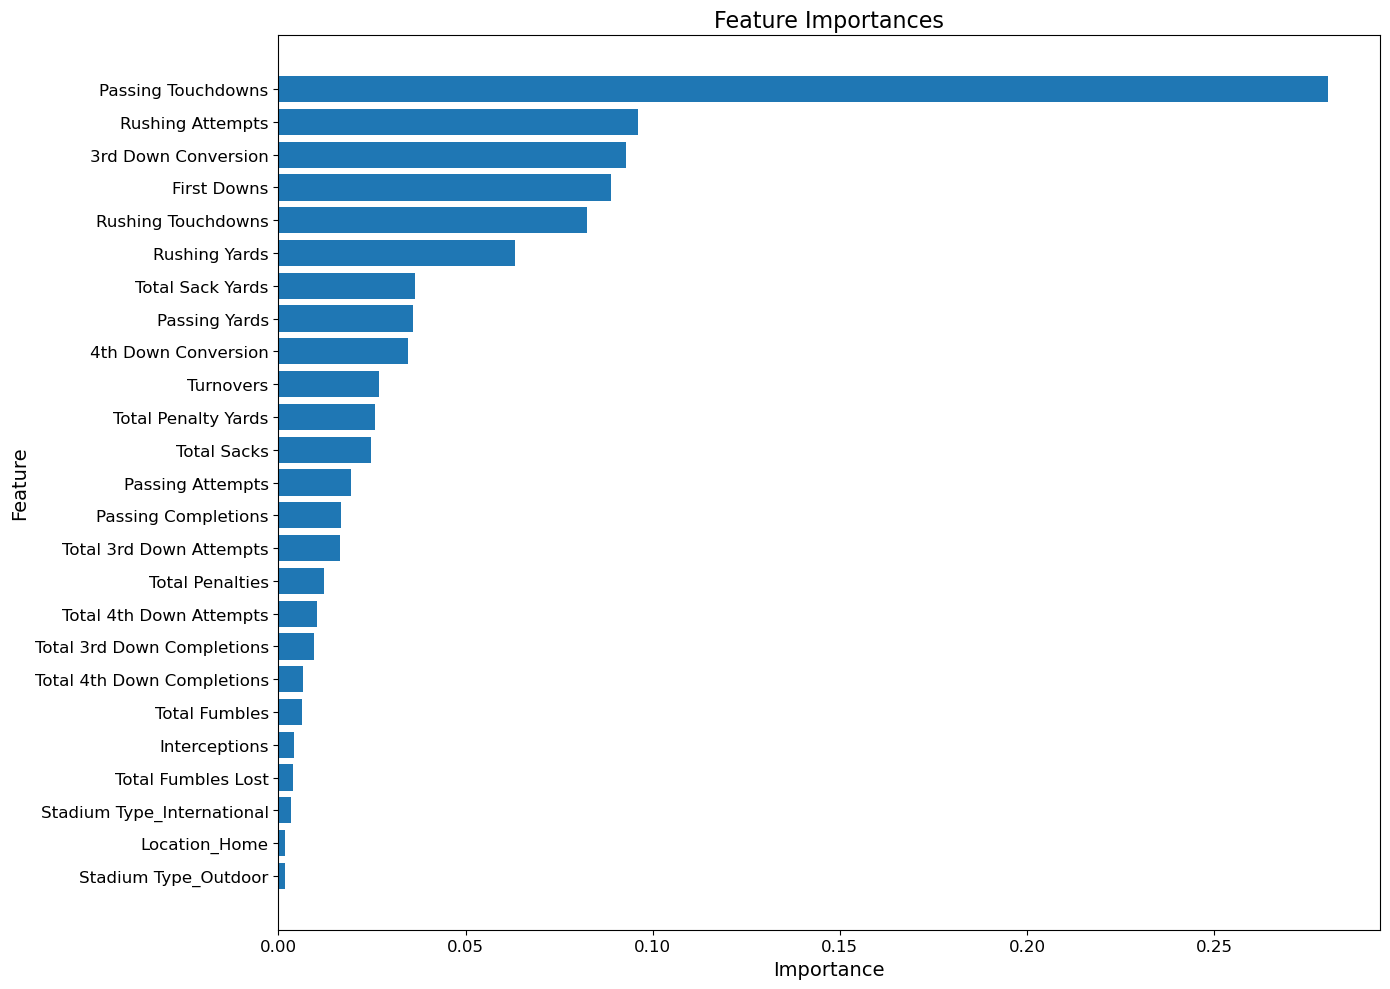

Least impactful features:
                       Feature  Importance
17             Total Penalties    0.012100
22     Total 4th Down Attempts    0.010278
20  Total 3rd Down Completions    0.009477
23  Total 4th Down Completions    0.006492
14               Total Fumbles    0.006199
11               Interceptions    0.004043
15          Total Fumbles Lost    0.003802
1   Stadium Type_International    0.003340
0                Location_Home    0.001827
2         Stadium Type_Outdoor    0.001762


In [17]:
# Plot the feature importances with adjusted figure size and font size
plt.figure(figsize=(14, 10))  # Increase the figure size
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance', fontsize=14)  # Increase font size for x-axis label
plt.ylabel('Feature', fontsize=14)  # Increase font size for y-axis label
plt.title('Feature Importances', fontsize=16)  # Increase font size for title
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)  # Increase font size for x-axis ticks
plt.yticks(fontsize=12)  # Increase font size for y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Display the least impactful features
print("Least impactful features:")
print(feature_importance_df.tail(10))

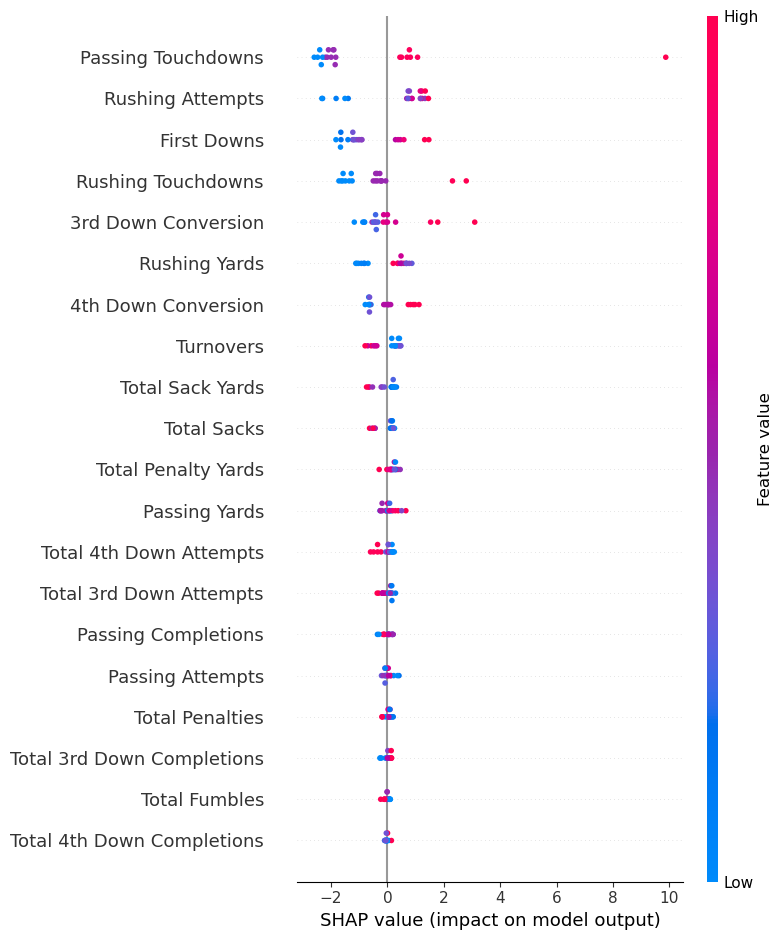

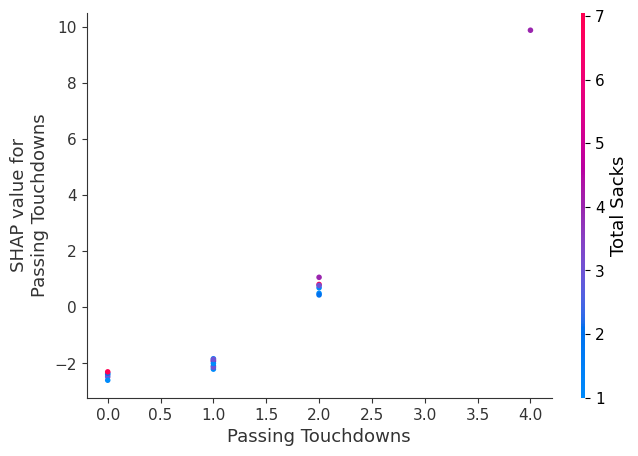

In [18]:
# Create a SHAP explainer using the trained model
explainer = shap.TreeExplainer(pipeline.named_steps['model'])

# Transform the test set using the preprocessor
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# Get the feature names from the preprocessor
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
all_feature_names = np.concatenate([onehot_columns, numeric_columns])

# Create a DataFrame for the transformed test set
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Summary plot
shap.summary_plot(shap_values, X_test_transformed_df, feature_names=all_feature_names)

# Dependence plot for a specific feature (e.g., the most important feature)
shap.dependence_plot(np.argmax(np.abs(shap_values).mean(0)), shap_values, X_test_transformed_df, feature_names=all_feature_names)

**Visualizing the difference in predicted value vs actual value**

In [20]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Create a DataFrame with the actual and predicted values
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['Difference'] = results_df['Actual'] - results_df['Predicted']

# Display the first few rows of the results DataFrame
results_df.head()

,Location,Stadium Type,First Downs,Rushing Attempts,Rushing Yards,Rushing Touchdowns,Passing Completions,Passing Attempts,Passing Yards,Passing Touchdowns,...,Total Penalty Yards,Total 3rd Down Attempts,Total 3rd Down Completions,3rd Down Conversion,Total 4th Down Attempts,Total 4th Down Completions,4th Down Conversion,Actual,Predicted,Difference
80,Away,Outdoor,16,37,188,1,13,19,202,1,...,75,14,5,0.357143,0,0,NaN,30,18.81,11.19
77,Home,Indoor,19,28,118,0,17,28,181,4,...,30,13,6,0.461538,1,1,1.0,34,32.29,1.71
73,Home,Indoor,17,18,77,0,21,34,207,1,...,30,9,1,0.111111,2,0,0.0,13,11.52,1.48
94,Away,Outdoor,22,32,108,3,21,23,254,2,...,28,9,5,0.555556,3,3,1.0,38,30.00,8.00
33,Home,Outdoor,20,34,139,0,25,39,225,1,...,50,15,7,0.466667,5,1,0.2,10,18.03,-8.03


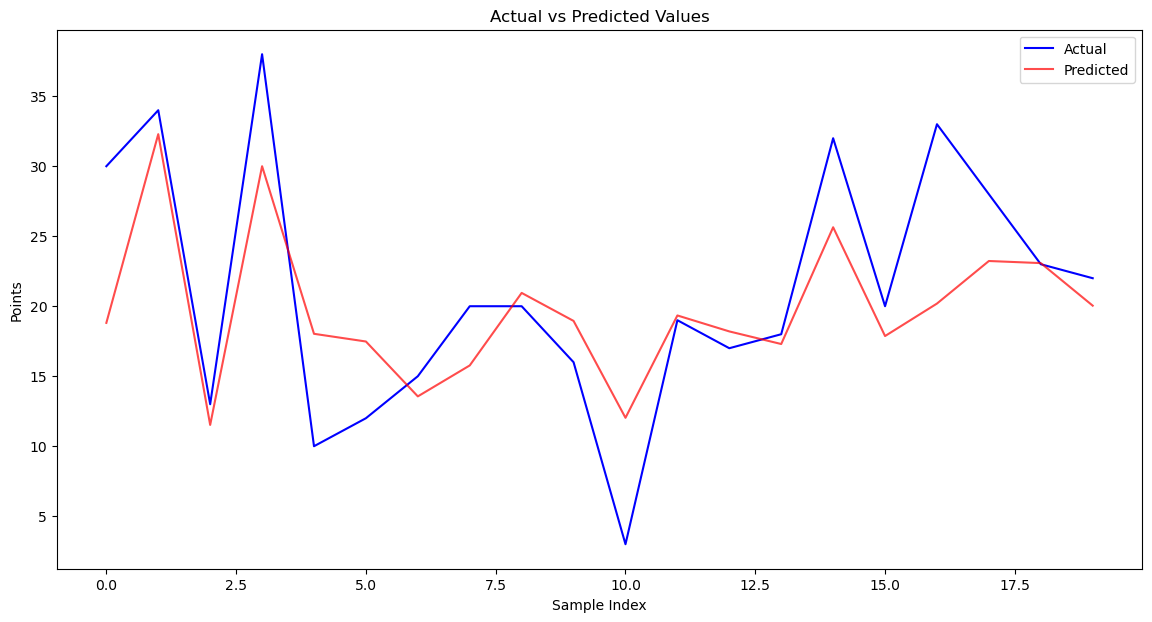

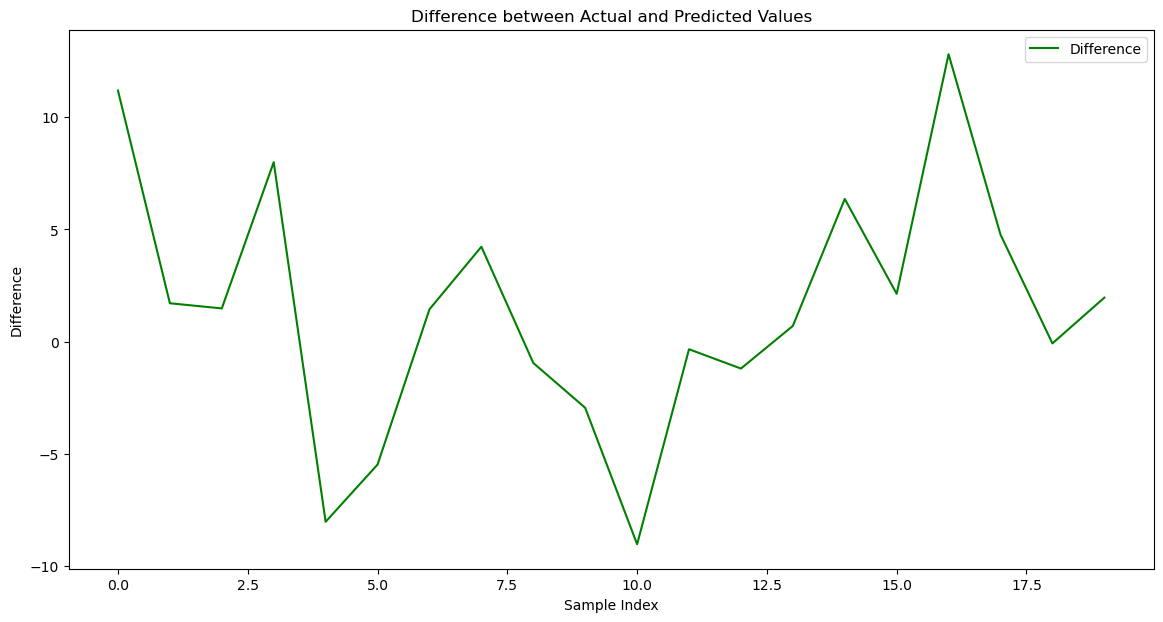

In [21]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(results_df['Actual'].values, label='Actual', color='blue')
plt.plot(results_df['Predicted'].values, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Points')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Plot the differences
plt.figure(figsize=(14, 7))
plt.plot(results_df['Difference'].values, label='Difference', color='green')
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Difference between Actual and Predicted Values')
plt.legend()
plt.show()